<a href="https://colab.research.google.com/github/pearl-yu/twitch_project/blob/main/10082022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Last updated: Oct 8th

# Digital Entrepreneurship Project - Main Notebook

## Coding wise
- Compiled the code to call endpoints:
  - User informtation 
    - Basic info: 'id', 'login', 'display_name', 'type', 'broadcaster_type',
       'description', 'profile_image_url', 'offline_image_url', 'view_count',
       'created_at'
    -  follows: 'from_id', 'from_login', 'from_name', 'to_id', 'to_login', 'to_name', 'followed_at'
  - Video information: 'id', 'stream_id', 'user_id', 'user_login', 'user_name', 'title', 'description', 'created_at', 'published_at', 'url', 'thumbnail_url', 'viewable', 'view_count', 'language', 'type', 'duration', 'muted_segments'. 
- Compiled the code to retreive schedule and aggregate to hourly, weekly variables. 
- Compiled the code to retrieve video ids of a streamer. (So that we can link user info and video info to one panel) **need to loop it, and add in more params to get all vids of a timeframe.**
- Compiled the code to retrieve chat files and video files.
  - Compiled the code to preprocess chat files. I've run LDA models, but decided the vanilla topic models are not that helpful.  **This is in another script, not this main one.**

Action items:
- Sample selection. [TwitchTracker](https://sullygnome.com/channels/30/followergrowth) **Need to figure this out!!!**
- Variable construction. And linking everything to a panel. **We're good on stream stats, but need one or two more days extracting variables from the chat file. Our key independent variables are mostly from there. **
- Setting up Github to host the dataset. (I know the procedures, but we need to basically download the github repo into this notebook everytime running it. Need to check on the storage space.) (This is not needed for now.)

## Insight wise
- [TwitchTracker Comparison](https://sullygnome.com/channel/schrodingerlee/30/compare/33093854_9127670_37733932) is helpful comparing streamers. 
[This guy](https://sullygnome.com/channel/avamind/30) and [this guy](https://sullygnome.com/channel/futives/30) for example, we can see that their content patterns are different. [This guy](https://sullygnome.com/channel/therealddosama/30) only streamed one game as he started. [This guy](https://sullygnome.com/channel/nykchazzaa/30) has a different pattern. 
  - We can see that some streamers starts with just one game, then expand to multiple games. Some streamers started out 'experimenting' on different games, then just switch to one game only. We also see some streamers alternate between multiple / one game only modes. This suggests that this might be a good dependent variable as there is variation. 

- In modeling leaving/fulltime/part time, I was looking at their streaming time patterns. From the schedule, of course strong weekly patterns cuz that's how they set the schedule. I haven't organized the panel with actual streaming time. **Need to do this.** I think to model this, we'll need long-period panel. Because from what I've seen, looking at just one-month period, not so drastic streaming schedule changes. Maybe there isn't that much variation in streaming time. 



## API setup

An application program interface (API) is code that allows two software programs to communicate with each other. The API defines the correct way for a developer to write a program that requests services from an operating system (OS) or other application.    
Twitch API documentation: https://dev.twitch.tv/docs/api

Get a regular twitch account.     
- Username: pearloct Password: Pearl@0711rr  
- Email used: peiyan.yu@outlook.com  

Go to https://dev.twitch.tv/console and register an application. Get client ID and Client secret there. (can request new client secret there.)
- client_id = 'tamrylbvlu3wub4r8c5fddwsou246x'
- client_secret= 'y4enh38kpiwkh7j00nqvv185ttsedw'

In [ ]:
import requests  # get the content from the API by using the get() method. json() method converts the API response to JSON format for easy handling.
import json   # to work with the returned json content from API.
import numpy as np
import pandas as pd

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

Generate app access token.

reference 1: https://github.com/BarryCarlyon/twitch_misc/tree/main/authentication/app_access_tokens/python   
reference 2: https://kaivalyapowale.com/2019/12/18/twitch-dashboard/

In [ ]:
## Pearl's credentials
client_id = 'tamrylbvlu3wub4r8c5fddwsou246x'
client_secret= 'y4enh38kpiwkh7j00nqvv185ttsedw'

In [ ]:
# Defining the URL to which we will make the request
url = 'https://id.twitch.tv/oauth2/token'

# Defining the parameters to be passed to the request
body = {
  'client_id'     : client_id,
  'client_secret' : client_secret,
  'grant_type'    : 'client_credentials'
}

# Making a POST request to the URL to retrieve the access token
access_code = requests.post(url, params=body)

#access token response is a JSON-encoded app access token
access_token = json.loads(access_code.text)
access_token = access_token['access_token']

# Beautifying and printing the response
print(access_token)
print(json.dumps(access_code.json(), indent=4))

lfokeml5jnpge1pdznwem4itqc05ai
{
    "access_token": "lfokeml5jnpge1pdznwem4itqc05ai",
    "expires_in": 5149744,
    "token_type": "bearer"
}


Now we have all the 'sign-in' information (three variables): client_id, client_secret, access_token   

Then in https://dev.twitch.tv/docs/api/reference, there're a list of 'Endpoints' that we can call. We can check on what information each endpoint returns in the Response part, the authentication token it requires (Anything that requires app access token we're fine.), parameters to specify. 

- So the python code to call each endpoint will be similar, almost the same. requests.get() This returns a json object. Sometimes we'll need loops to loop through a list of game ids, or user ids, or stream ids. 
- Next part of the python code is just handling the dataset with json package, turning the returned json object to a python object.     
- Then pandas comes in. We need to figure out the panel structure first.   

**Panel structure**   Note in progress. Ignore this. Messy.    
We can get, for example hourly dataset. But I'm fine with stream-level dataset, so each observation is a stream.   
Each stream, I'd image it to be a document.   

Ultimately, what do we want? 
- Check if streamers want to leave, become full or part time: From the schedule, we can calculate daily/weekly streaming time/ freqeuncy. We can have one dataframe, with streamer id, date, streaming_length, streaming_frequency. *10072022*
    - Once we have this, we can plot it out, maybe to classify the streamers' streaming patterns. **
    - So one problem, how to select the streamer ids? We want a random sample. My impression of the API is that it returns top streamers of a category. How to select the sample? Maybe we can use search?
- We can also use actual streaming time. That would require us to retrive stream video ids of a certain streamer. 
- Check on their content choices. This seems to be harder, involving ML techniques. I'll leave it for later. 
- Check their social media connecting states. 

- With some independent variables, I think we can have a stream level one, views, number of chats, what can be extracted from the chats.
    - Need to pull chat data based on video ids. And better to write another another script to pre-process.

Reference to write markdown: https://www.markdownguide.org/basic-syntax/#italic   

## SQL like code 
These would be needed to link together user information and video information. 

We will first access the API for Top 100 Games by number of viewers. Using the Game IDs for these games, we will get Stream data for them.
- This is only useful to test things. Won't be needed later once we've selected a sample. 

In [ ]:
# Getting data for Top 5 Games by number of viewers
# Default response is for 20 games so you will have to set the parameter 'first to 5'

headers = {
    'Authorization' : 'Bearer '+str(access_token),
    'Client-Id' : client_id
}

# The response will be a JSON which will include the response data and the pagination cursor
games_response = requests.get('https://api.twitch.tv/helix/games/top?first=20&#39', headers=headers)
# We need to extract the data from the JSON and convert it into a pandas dataframe
games_response_json = json.loads(games_response.text)
topgames_data = games_response_json['data']
# Converting to a pandas dataframe
topgames_df = pd.DataFrame.from_dict(json_normalize(topgames_data), orient='columns')

# See the first few lines. The response includes id, name, and box art url for the game
topgames_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


,id,name,box_art_url
0,21779,League of Legends,https://static-cdn.jtvnw.net/ttv-boxart/21779-...
1,509658,Just Chatting,https://static-cdn.jtvnw.net/ttv-boxart/509658...
2,32399,Counter-Strike: Global Offensive,https://static-cdn.jtvnw.net/ttv-boxart/32399_...
3,515025,Overwatch 2,https://static-cdn.jtvnw.net/ttv-boxart/515025...
4,32982,Grand Theft Auto V,https://static-cdn.jtvnw.net/ttv-boxart/32982_...


To get the Top Streams for these games we will have to pass the game IDs as strings in the API call one at a time. For this, we need to create a FOR loop to get data for all the Games.

In [ ]:
headers = {
            'Authorization' : 'Bearer '+str(access_token),
            'Client-Id' : client_id
        }

topstreamsforgame_df = pd.DataFrame()
for i in range(1,19) :        
        topstreamsforgame_response = requests.get('https://api.twitch.tv/helix/streams?game_id='+str(topgames_df['id'][i])+'&first=100', headers=headers)
    
        topstreamsforgame_response_json = json.loads(topstreamsforgame_response.text)
        topstreamsforgame_data = topstreamsforgame_response_json['data']
        topstreamsforgame_df_temp = pd.DataFrame.from_dict(json_normalize(topstreamsforgame_data), orient='columns')
    
        frames = [topstreamsforgame_df, topstreamsforgame_df_temp]
        topstreamsforgame_df = pd.concat(frames, ignore_index=True)

print(topstreamsforgame_df.shape)
print(topstreamsforgame_df.columns)
topstreamsforgame_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':


(1662, 14)
Index(['id', 'user_id', 'user_login', 'user_name', 'game_id', 'game_name',
       'type', 'title', 'viewer_count', 'started_at', 'language',
       'thumbnail_url', 'tag_ids', 'is_mature'],
      dtype='object')


,id,user_id,user_login,user_name,game_id,game_name,type,title,viewer_count,started_at,language,thumbnail_url,tag_ids,is_mature
0,41371318651,207813352,hasanabi,HasanAbi,509658,Just Chatting,live,TWITCHCON LAST DAY!,33447,2022-10-09T20:52:37Z,en,https://static-cdn.jtvnw.net/previews-ttv/live...,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False
1,39929346424,77827128,tumblurr,Tumblurr,509658,Just Chatting,live,🥵IL RITORNO🥵REACTION🥵| !thesandbox !indirizzo ...,21600,2022-10-09T19:14:46Z,it,https://static-cdn.jtvnw.net/previews-ttv/live...,[5b9935eb-1e9a-4217-98ad-62bda5cff0d1],False
2,40326282537,168732568,westcol,WestCOL,509658,Just Chatting,live,PMPL LATAM Fall S7 D3 | Spring | SOLO REYES,20541,2022-10-09T21:50:08Z,es,https://static-cdn.jtvnw.net/previews-ttv/live...,[d4bb9c58-2141-4881-bcdc-3fe0505457d1],False
3,40325895337,28579002,cellbit,Cellbit,509658,Just Chatting,live,🐺DIA DE REDDIT🐺TERROR COM A LORENA DEPOIS 🐺 RO...,18025,2022-10-09T20:35:09Z,pt,https://static-cdn.jtvnw.net/previews-ttv/live...,[39ee8140-901a-4762-bfca-8260dea1310f],False
4,40326148377,106820088,carreraaa,Carreraaa,509658,Just Chatting,live,un año más viejo 🎂 sigo midiendo lo mismo 👍,17178,2022-10-09T21:24:38Z,es,https://static-cdn.jtvnw.net/previews-ttv/live...,[d4bb9c58-2141-4881-bcdc-3fe0505457d1],False


In [ ]:
topstreamsforgame_df.to_csv ('topstreamsforgames.csv', index = None, header=True)

Below is the code block to retrieve past videos if not deleted by a streamer. Need to loop this, can add in params to specify start date. 

In [ ]:
# endpoint: https://dev.twitch.tv/docs/api/reference#get-videos

headers = {
            'Authorization' : 'Bearer '+str(access_token),
            'Client-Id' : client_id
        }

parameters = {
    'user_id'   : '12826',  # Official Twitch channel
    'sort'      : 'views'
}

response = requests.get('https://api.twitch.tv/helix/videos',
                        headers=headers, params=parameters)

response_json = json.loads(response.text)
response_data = response_json['data']
response_df = pd.DataFrame.from_dict(json_normalize(response_data), orient='columns')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [ ]:
response_df.head()

,id,stream_id,user_id,user_login,user_name,title,description,created_at,published_at,url,thumbnail_url,viewable,view_count,language,type,duration,muted_segments
0,799499623,1,12826,twitch,Twitch,Twitch's Channel Trailer,,2020-11-11T19:37:49Z,2020-11-11T19:41:14Z,https://www.twitch.tv/videos/799499623,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,2466630,en,upload,29s,None
1,802833208,40483690382,12826,twitch,Twitch,This is GlitchCon.,So you want to go through a portal hidden in t...,2020-11-14T16:05:53Z,2020-11-14T16:05:53Z,https://www.twitch.tv/videos/802833208,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,9595993,en,archive,13h54m12s,None
2,150942279,25478677344,12826,twitch,Twitch,EA PLAY LIVE 2017,"EA's big show, brought to you as part of E3 on...",2017-06-10T22:07:32Z,2017-06-10T22:07:32Z,https://www.twitch.tv/videos/150942279,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,341919,en,highlight,2h57m46s,None
3,271706096,29039486720,12826,twitch,Twitch,"E3 on Twitch - Sunday - Microsoft, Bethesda, D...",,2018-06-10T18:00:59Z,2018-06-10T18:00:59Z,https://www.twitch.tv/videos/271706096,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,289160,en,archive,9h22m18s,None
4,800558240,40453010926,12826,twitch,Twitch,BUILD YOUR PORTAL PASS,,2020-11-12T19:14:15Z,2020-11-12T19:14:15Z,https://www.twitch.tv/videos/800558240,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,365090,en,archive,15m55s,None


In [ ]:
def api_info(url = 'https://api.twitch.tv/helix/users?id=', key_series = topstreamsforgame_df['user_id'], n = 5):
    
    headers = {
            'Authorization' : 'Bearer '+str(access_token),
            'Client-Id' : client_id
        }

    temp_df = pd.DataFrame()
    for i in range(0,5) :
        temp_response = requests.get(url+str(key_series[i]), headers=headers)
        # Load the JSON
        temp_response_json = json.loads(temp_response.text)
        if list(temp_response_json.keys())[0] == 'error':
            continue
        else:
            temp_data = temp_response_json['data']
            temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')
        
            frames = [temp_df, temp_df_temp]
            temp_df = pd.concat(frames, ignore_index=True)
    
    print(temp_df.shape)
    print(temp_df.columns)
    
    return temp_df

In [ ]:
# https://dev.twitch.tv/docs/api/reference#get-users
user_df = api_info(url = 'https://api.twitch.tv/helix/users?id=', key_series =topstreamsforgame_df['user_id'], n = 5)
user_df.head()

<ipython-input-37-902219074fab>:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')


(5, 10)
Index(['id', 'login', 'display_name', 'type', 'broadcaster_type',
       'description', 'profile_image_url', 'offline_image_url', 'view_count',
       'created_at'],
      dtype='object')


,id,login,display_name,type,broadcaster_type,description,profile_image_url,offline_image_url,view_count,created_at
0,238813810,eliasn97,eliasn97,,partner,FORTNITE FRAGGER/ among us Elite 2 Spieler/Lan...,https://static-cdn.jtvnw.net/jtv_user_pictures...,,23276036,2018-07-15T12:43:44Z
1,52091823,castro_1021,Castro_1021,,partner,Trying to make people smile since 2013 ♥️,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,136380441,2013-11-24T08:42:28Z
2,407388596,aminematue,aminematue,,partner,Je suis un mec cool ll contactaminematue@gmail...,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,14850012,2019-01-06T21:33:00Z
3,64342766,trymacs,Trymacs,,partner,Moin Leute!,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,148149322,2014-06-14T12:17:50Z
4,125036509,gamerbrother,GamerBrother,,partner,Ruhiger Streamer deines Vertrauens.,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,3622722,2016-05-24T18:05:07Z


In [ ]:
# https://dev.twitch.tv/docs/api/reference#get-channel-information
channel_df = api_info(url = 'https://api.twitch.tv/helix/channels?broadcaster_id=', key_series =topstreamsforgame_df['user_id'], n = 5)
channel_df.head()

<ipython-input-37-902219074fab>:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')


(5, 8)
Index(['broadcaster_id', 'broadcaster_login', 'broadcaster_name',
       'broadcaster_language', 'game_id', 'game_name', 'title', 'delay'],
      dtype='object')


,broadcaster_id,broadcaster_login,broadcaster_name,broadcaster_language,game_id,game_name,title,delay
0,238813810,eliasn97,eliasn97,de,1745202732,FIFA 23,DIE REISE ZUM WL ERDKERN!🦴 | !elevate !eligella,0
1,52091823,castro_1021,Castro_1021,en,1745202732,FIFA 23,LETS GOOOOOOO @Castro1021,0
2,407388596,aminematue,aminematue,fr,1745202732,FIFA 23,ON PACK ENFIN UN GRAND JOUEUR EA SVP JE VOUS E...,0
3,64342766,trymacs,Trymacs,de,1745202732,FIFA 23,ERSTE FIFA Weekend League! !tickets,0
4,125036509,gamerbrother,GamerBrother,de,1745202732,FIFA 23,48 Stunden Stream mit Tisi 🔥 FIFA 23 Rttk Pack...,0


In [ ]:
# https://dev.twitch.tv/docs/api/reference#get-users-follows
follow_df = api_info(url = 'https://api.twitch.tv/helix/users/follows?to_id=', key_series =topstreamsforgame_df['user_id'], n = 5)
follow_df.head()

<ipython-input-37-902219074fab>:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')


(100, 7)
Index(['from_id', 'from_login', 'from_name', 'to_id', 'to_login', 'to_name',
       'followed_at'],
      dtype='object')


,from_id,from_login,from_name,to_id,to_login,to_name,followed_at
0,519811321,97spgt,97spgt,238813810,eliasn97,eliasn97,2022-10-07T20:41:58Z
1,510705960,zein_harabeh,zein_harabeh,238813810,eliasn97,eliasn97,2022-10-07T20:41:56Z
2,436560547,60tonnenronny,60tonnenronny,238813810,eliasn97,eliasn97,2022-10-07T20:41:52Z
3,623178776,turkishsoldier_68,turkishsoldier_68,238813810,eliasn97,eliasn97,2022-10-07T20:41:51Z
4,835628646,juuuuudebellingham22,juuuuudebellingham22,238813810,eliasn97,eliasn97,2022-10-07T20:41:49Z


In [ ]:
# https://dev.twitch.tv/docs/api/reference#get-videos
video_df = api_info(url = 'https://api.twitch.tv/helix/videos?user_id=', key_series = topstreamsforgame_df['user_id'], n = 5)
video_df.head()

<ipython-input-37-902219074fab>:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')


(66, 17)
Index(['id', 'stream_id', 'user_id', 'user_login', 'user_name', 'title',
       'description', 'created_at', 'published_at', 'url', 'thumbnail_url',
       'viewable', 'view_count', 'language', 'type', 'duration',
       'muted_segments'],
      dtype='object')


,id,stream_id,user_id,user_login,user_name,title,description,created_at,published_at,url,thumbnail_url,viewable,view_count,language,type,duration,muted_segments
0,1588065608,46050246396,238813810,eliasn97,eliasn97,REAL LIFE ELIGELLA CUP II - (Only Chat) 🔥⚽ | !...,,2022-09-11T12:45:19Z,2022-09-11T12:45:19Z,https://www.twitch.tv/videos/1588065608,https://static-cdn.jtvnw.net/cf_vods/dgeft87wb...,public,911261,de,archive,6h19m0s,None
1,1616688917,1,52091823,castro_1021,Castro_1021,Highlight: WHO WILL I GET IN REWARDS?? @Castr...,,2022-10-07T17:58:54Z,2022-10-07T17:58:54Z,https://www.twitch.tv/videos/1616688917,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,40,en,highlight,9m4s,None
2,1614661433,47266032317,52091823,castro_1021,Castro_1021,LETS GOOOOOOO @Castro1021,,2022-10-07T14:15:54Z,2022-10-07T14:15:54Z,https://www.twitch.tv/videos/1614661433,,public,925,en,archive,6h32m42s,None
3,1610861429,47261188717,52091823,castro_1021,Castro_1021,WHO WILL I GET IN REWARDS?? @Castro1021,,2022-10-06T14:15:33Z,2022-10-06T14:15:33Z,https://www.twitch.tv/videos/1610861429,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,504587,en,archive,7h3m20s,None
4,1609984375,47256231981,52091823,castro_1021,Castro_1021,HAALAND INFORMMMMM @Castro1021,,2022-10-05T14:22:46Z,2022-10-05T14:22:46Z,https://www.twitch.tv/videos/1609984375,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,416013,en,archive,5h39m0s,None


### schedule

In [ ]:
headers = {
            'Authorization' : 'Bearer '+str(access_token),
            'Client-Id' : client_id
        }

schedule_df = pd.DataFrame()
segment_df = pd.DataFrame()
for i in range(0,100) :
    schedule_response = requests.get('https://api.twitch.tv/helix/schedule?broadcaster_id='+str(topstreamsforgame_df['user_id'][i]), headers=headers)
    # Load the JSON
    schedule_response_json = json.loads(schedule_response.text)
    if list(schedule_response_json.keys())[0] == 'error':
        continue
    else:
        schedule_data = schedule_response_json['data']
        schedule_df_temp = pd.DataFrame.from_dict(json_normalize(schedule_data), orient='columns')
        
        frames = [schedule_df, schedule_df_temp]
        schedule_df = pd.concat(frames, ignore_index=True)
        
        if schedule_response_json['data']['segments'] == None:
            continue
        else:
            schedule_segment_data = schedule_response_json['data']['segments']
            segment_df_temp = pd.DataFrame.from_dict(json_normalize(schedule_segment_data), orient='columns')
            segment_df_temp['broadcaster_id'] = schedule_data['broadcaster_id']
            segment_df_temp['broadcaster_name'] = schedule_data['broadcaster_name']
            segment_df_temp['vacation'] = schedule_data['vacation']
            
            frames = [segment_df,segment_df_temp]
            segment_df = pd.concat(frames, ignore_index=True)

print('Streamers that has a schedule enabled are returned', schedule_df.shape)
print('Streamers that scheduled streams are returned', segment_df.shape)

<ipython-input-187-3af6e2b68765>:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  schedule_df_temp = pd.DataFrame.from_dict(json_normalize(schedule_data), orient='columns')
<ipython-input-187-3af6e2b68765>:25: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  segment_df_temp = pd.DataFrame.from_dict(json_normalize(schedule_segment_data), orient='columns')


Streamers that has a schedule enabled are returned (15, 5)
Streamers that scheduled streams are returned (221, 12)


In [ ]:
schedule_df.head()

,segments,broadcaster_id,broadcaster_name,broadcaster_login,vacation
0,None,125036509,GamerBrother,gamerbrother,None
1,[{'id': 'eyJzZWdtZW50SUQiOiJhYmVhOTMyNy1lYzg1L...,143424503,dannyaarons,dannyaarons,None
2,[{'id': 'eyJzZWdtZW50SUQiOiI4ZmVkZWUwYy1iYjI0L...,49303276,Nick28T,nick28t,None
3,[{'id': 'eyJzZWdtZW50SUQiOiI5YWViMDM1MS04MWFlL...,42143654,fuji720x,fuji720x,None
4,[{'id': 'eyJzZWdtZW50SUQiOiJhNGEyNjcxYy1jZDNlL...,64080424,Roxasorg13th,roxasorg13th,None


In [ ]:
# It's interesting that there's a vacation option
segment_df.head()

,id,start_time,end_time,title,canceled_until,category,is_recurring,category.id,category.name,broadcaster_id,broadcaster_name,vacation
0,eyJzZWdtZW50SUQiOiJhYmVhOTMyNy1lYzg1LTRjMWYtOW...,2022-10-08T13:00:00Z,2022-10-08T17:00:00Z,Champs #2,None,NaN,True,NaN,NaN,143424503,dannyaarons,None
1,eyJzZWdtZW50SUQiOiI5ZDFhZjE0ZS05NzE1LTQ0NGQtYW...,2022-10-10T14:00:00Z,2022-10-10T17:00:00Z,Career,None,NaN,True,1869092879,FIFA 22,143424503,dannyaarons,None
2,eyJzZWdtZW50SUQiOiJlNTQ2NjJjYi03NGQyLTRlYjgtOT...,2022-10-11T14:00:00Z,2022-10-11T17:00:00Z,Draft/Career Challenge,None,NaN,True,NaN,NaN,143424503,dannyaarons,None
3,eyJzZWdtZW50SUQiOiI2MmE4YjFkOC02MTVhLTQwZTEtYW...,2022-10-12T14:00:00Z,2022-10-12T17:00:00Z,Playoffs/Champs Challenge,None,NaN,True,NaN,NaN,143424503,dannyaarons,None
4,eyJzZWdtZW50SUQiOiIwZWI2ZmQxMy01ZjQxLTQxNzUtOD...,2022-10-14T14:00:00Z,2022-10-14T17:00:00Z,Champs,None,NaN,True,NaN,NaN,143424503,dannyaarons,None


Now, we can try to aggregate this and run some exploratory analysis.

In [ ]:
# deal with time stamp and extract date - reference: https://datagy.io/pandas-extract-date-from-datetime/
segment_df['start_time'] = pd.to_datetime(segment_df['start_time'])
segment_df['end_time'] = pd.to_datetime(segment_df['end_time'])

segment_df['date'] = segment_df['start_time'].dt.date
segment_df['week'] = segment_df['start_time'].dt.week

segment_df.loc[segment_df["canceled_until"].isnull(), "canceled"] = 0  ## I'm not sure if this line is correct
segment_df.loc[segment_df["is_recurring"] ==True, "recurring"] = 1 ## I'm not sure if this line is correct

# refrence: https://stackoverflow.com/questions/22923775/calculate-time-difference-between-two-pandas-columns-in-hours-and-minutes
segment_df['duration'] = (segment_df['end_time'] - segment_df['start_time']).astype('timedelta64[h]')

<ipython-input-190-5aa3c13cfaa6>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  segment_df['week'] = segment_df['start_time'].dt.week


In [ ]:
# aggregation -reference: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
aggregations = {
    'broadcaster_name': 'first',
    'vacation':'first',
    'canceled':'sum',
    'recurring':'sum',
    'title' : 'nunique',
    'category' : 'nunique',
    'duration':[min,max,sum,'mean','count'],
}

In [ ]:
daily_schedule_df = segment_df.groupby(['broadcaster_id','date']).agg(aggregations)

print(daily_schedule_df.shape)
daily_schedule_df.head(10)

(221, 11)


broadcaster_name vacation canceled recurring  \
                                     first    first      sum       sum   
broadcaster_id date                                                      
112042948      2022-10-08          ConanGW     None      0.0       1.0   
               2022-10-09          ConanGW     None      0.0       1.0   
               2022-10-10          ConanGW     None      0.0       1.0   
               2022-10-11          ConanGW     None      0.0       1.0   
               2022-10-12          ConanGW     None      0.0       1.0   
               2022-10-13          ConanGW     None      0.0       1.0   
               2022-10-14          ConanGW     None      0.0       1.0   
               2022-10-15          ConanGW     None      0.0       1.0   
               2022-10-16          ConanGW     None      0.0       1.0   
               2022-10-17          ConanGW     None      0.0       1.0   

                            title category duration                       
                          nunique  nunique      min  max  sum mean count  
broadcaster_id date                                                       
112042948      2022-10-08       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-09       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-10       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-11       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-12       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-13       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-14       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-15       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-16       1        0      3.0  3.0  3.0  3.0     1  
               2022-10-17       1        0      3.0  3.0  3.0  3.0     1

In [ ]:
weekly_schedule_df = segment_df.groupby(['broadcaster_id','week']).agg(aggregations)

print(weekly_schedule_df.shape)
weekly_schedule_df.head(10)

(97, 11)


broadcaster_name vacation canceled recurring   title  \
                               first    first      sum       sum nunique   
broadcaster_id week                                                        
112042948      40            ConanGW     None      0.0       2.0       1   
               41            ConanGW     None      0.0       7.0       1   
               42            ConanGW     None      0.0       7.0       1   
               43            ConanGW     None      0.0       4.0       1   
117209801      40           Seals311     None      0.0       1.0       1   
               41           Seals311     None      0.0       6.0       2   
               42           Seals311     None      0.0       6.0       2   
               43           Seals311     None      0.0       6.0       2   
               44           Seals311     None      0.0       1.0       1   
143424503      40        dannyaarons     None      0.0       1.0       1   

                    category duration                             
                     nunique      min  max   sum      mean count  
broadcaster_id week                                               
112042948      40          0      3.0  3.0   6.0  3.000000     2  
               41          0      3.0  3.0  21.0  3.000000     7  
               42          0      3.0  3.0  21.0  3.000000     7  
               43          0      3.0  3.0  12.0  3.000000     4  
117209801      40          0      6.0  6.0   6.0  6.000000     1  
               41          0      6.0  8.0  44.0  7.333333     6  
               42          0      6.0  8.0  44.0  7.333333     6  
               43          0      6.0  8.0  44.0  7.333333     6  
               44          0      8.0  8.0   8.0  8.000000     1  
143424503      40          0      4.0  4.0   4.0  4.000000     1

From plots below, we can classify streamers into different categories, but like, their schedules are mostly recurring. 
- Maybe we should use actual sessions. 
- If just schedule, we need to find people who changed their schedule at some point. Like, is there within-streamer variation?
    - I don't expect people to change their schedule frequently if the schedule are set in a recurring fashion. This means that one month is not enough. Figure out how to pull schedules of longer time ago. I think the API has a param to specify, like start time. But I'm not sure. Need to check on that.

In [ ]:
def plot_trend(df = weekly_schedule_df,variable = 'mean', title = 'Total scheduled session duration',xlabel = 'Weeks'):
    broadcaster_ids = list(set(df.index.get_level_values(0)))

    clean_table = df.loc['112042948'][[('duration',variable)]]
    clean_table.rename({variable: '112042948'}, axis=1, inplace=True)
    
    for broadcaster_id in broadcaster_ids:
        if broadcaster_id != '112042948':
            clean_table[broadcaster_id] = df.loc[broadcaster_id][[('duration',variable)]]
    
    # to set the plot size
    plt.figure(figsize=(20, 10), dpi=150)
    clean_table.plot(label='fhfjhf',legend=None)
    
    plt.title(title) # adding title
    plt.xlabel(xlabel) # adding label to x-axis
    #plt.legend() # adding legend.
    plt.show()

<Figure size 3000x1500 with 0 Axes>

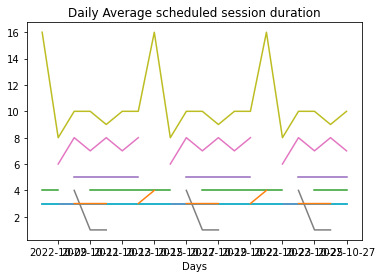

<Figure size 3000x1500 with 0 Axes>

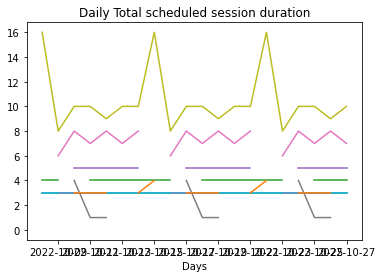

<Figure size 3000x1500 with 0 Axes>

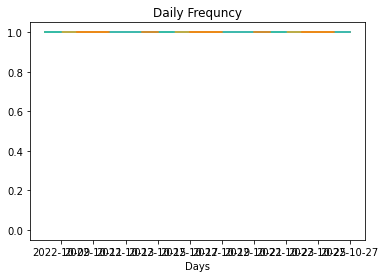

In [ ]:
plot_trend(df = daily_schedule_df,variable = 'mean', title = 'Daily Average scheduled session duration',xlabel = 'Days')
plot_trend(df = daily_schedule_df,variable = 'sum', title = 'Daily Total scheduled session duration',xlabel = 'Days')
plot_trend(df = daily_schedule_df,variable = 'count', title = 'Daily Frequncy',xlabel = 'Days')

<Figure size 3000x1500 with 0 Axes>

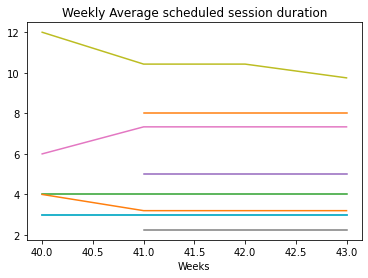

<Figure size 3000x1500 with 0 Axes>

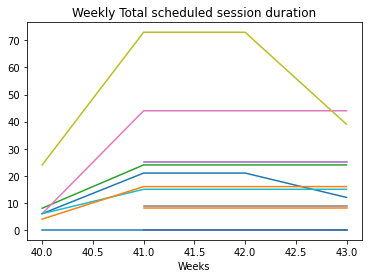

<Figure size 3000x1500 with 0 Axes>

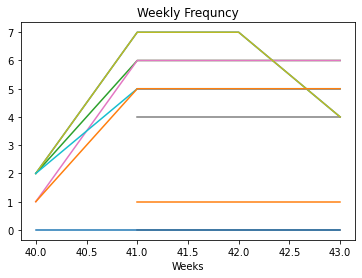

In [ ]:
plot_trend(df = weekly_schedule_df,variable = 'mean', title = 'Weekly Average scheduled session duration',xlabel = 'Weeks')
plot_trend(df = weekly_schedule_df,variable = 'sum', title = 'Weekly Total scheduled session duration',xlabel = 'Weeks')
plot_trend(df = weekly_schedule_df,variable = 'count', title = 'Weekly Frequncy',xlabel = 'Weeks')

### Code below is reorganized into the chat_processing script. Later we can just call the script here if needed.

In [ ]:
url = "https://wind-bow.glitch.me/twitch-api/channels/freecodecamp"
JSONContent = requests.get(url).json()
content = json.dumps(JSONContent, indent = 4, sort_keys=True)
print(content)

In [ ]:
import pandas as pd
import requests
import json

In [ ]:
url = "https://wind-bow.glitch.me/twitch-api/channels/freecodecamp"
JSONContent = requests.get(url).json()
content = json.dumps(JSONContent, indent = 4,sort_keys=True)
print(content)

In [ ]:
from twitch import TwitchClient

In [ ]:
# Important Constants for Connection to Twitch Channel Feed
server = 'irc.chat.twitch.tv'
port = 6667
nickname = 'pearloct' # '<YOUR_USERNAME>'
token = 'oauth:2sm0pqqle0osx42qf9al4gmjqrjts7'
channel = '#sweet_anita' # The hashtag before the username here is SUPER important. 

In [ ]:
import socket
sock = socket.socket()
sock.settimeout(120)

In [ ]:
sock.connect((server,port))

In [ ]:
# where 'utf-8' encoding encodes the string into bytes which allows it to be sent over the socket. 
sock.send(f"PASS {token}\n".encode('utf-8')) # carries token 
sock.send(f"NICK {nickname}\n".encode('utf-8')) # carries nickname
sock.send(f"JOIN {channel}\n".encode('utf-8')) # carries channel 

In [ ]:
resp = sock.recv(2048).decode('utf-8') #2048 is the buffer size in bytes, amount of data to recieve. 

In [ ]:
# Currently, the socket gets responses but we need to check for new messages and log messages as they come in. 
# The proper way to do this is to set up a logger that writes messages to a file and a loop that will check for new messages as the socket's open. 

import logging

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s — %(message)s',
                    datefmt='%Y-%m-%d_%H:%M:%S',
                    handlers=[logging.FileHandler('chat3.log', encoding='utf-8')]) # I called it "chat3.log", you can call it anything .log

# Debug means all levels of logging can be written to the file. 
# Format is how we want the line to look, which will be time/message. Date format is how the time of the format is recorded. 
# FileHandler to handlers is passed which creates a file in the directory and logs info to chat.log. 

In [ ]:
# Continuously checking for new messages in a loop. When connected to IRC, we want to make sure to send "PONG" if server sends "PING."
# Also want to parse emojis so they can be written to a file. There's an emoji library that maps emoji to word meaning. 

from emoji import demojize

while True:
    resp = sock.recv(2048).decode('utf-8')

    if resp.startswith('PING'):
        sock.send("PONG\n".encode('utf-8'))
    
    elif len(resp) > 0:
        logging.info(demojize(resp))
        
# This will keep running until you stop it. 
# To see the messages in real-time open a new terminal, navigate to the log's location, and run tail -f chat.log.

In [ ]:
sock.close() # Use this to open/close the socket. 

In [ ]:
import pandas as pd
from datetime import datetime
import re

def get_chat_dataframe(file):
    data = []

    with open(file, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
        
        for line in lines:
            try:
                time_logged = line.split('—')[0].strip()
                time_logged = datetime.strptime(time_logged, '%Y-%m-%d_%H:%M:%S')

                username_message = line.split('—')[1:]
                username_message = '—'.join(username_message).strip()

                username, channel, message = re.search(
                    ':(.*)\!.*@.*\.tmi\.twitch\.tv PRIVMSG #(.*) :(.*)', username_message
                ).groups()

                d = {
                    'dt': time_logged,
                    'channel': channel,
                    'username': username,
                    'message': message
                }

                data.append(d)
            
            except Exception:
                pass
            
    return pd.DataFrame().from_records(data)

In [ ]:
df = get_chat_dataframe('chat3.log') # I called it chat3.log, you can call it whatever you called it previously. 

print(df.shape)

df

df.drop(1248, inplace=True)# doing this because I want to remove a blank message. 

# If you have blank messages in the dataframe, it will create complications later down the line. Please fix this now! 
# I admit there are more systematic ways to remove blank messages than a manual df.drop. 

In [ ]:
client = TwitchClient(client_id='tamrylbvlu3wub4r8c5fddwsou246x',
                     oauth_token='oauth:2sm0pqqle0osx42qf9al4gmjqrjts7')

In [ ]:
client = TwitchClient(client_id='<tamrylbvlu3wub4r8c5fddwsou246x>', 
                      oauth_token='<oauth:wcecmdml7mafiwzqr0o6f1kd4uud3i>')

In [ ]:
emotes = client.chat.get_all_emoticons()

In [ ]:


client = TwitchClient(client_id='<my client id>')
channel = client.channels.get_by_id(44322889)

print(channel.id)
print(channel.name)
print(channel.display_name)